In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix,precision_score,recall_score
from xgboost.sklearn import XGBClassifier

from imblearn.under_sampling import RandomUnderSampler,NeighbourhoodCleaningRule,TomekLinks

import warnings
warnings.filterwarnings("ignore", category=Warning)

In [2]:
def rellenarNan(df,n,columnas_anuales,verbose=0):

    df_copia = df.copy()
    extremos = 0
    grupos_3 = 0
    grupos_4 = 0
    grupos_5 = 0

    indices = range(n-1,-1,-1)

    print('------------Rellenando extremos----------')
    # Si hay nan-dato o dato-nan en los extremos, se llena con el dato
    for j in range(len(df)):
        for columna in columnas_anuales:
            if  np.isnan(df.loc[j,columna +'-{}'.format(str(indices[0]))])==True and np.isnan(df.loc[j,columna +'-{}'.format(str(indices[1]))])==False:
                    df_copia.loc[j,columna +'-{}'.format(str(indices[0]))] = df_copia.loc[j, columna +'-{}'.format(str(indices[1]))]
                    if verbose:
                        print(j,'-->',df.loc[j,columna +'-{}'.format(str(indices[0]))],df.loc[j,columna +'-{}'.format(str(indices[1]))])
                    extremos += 1

            if  np.isnan(df.loc[j,columna +'-{}'.format(str(indices[-1]))])==True and np.isnan(df.loc[j,columna +'-{}'.format(str(indices[-2]))])==False:
                    df_copia.loc[j, columna +'-{}'.format(str(indices[-1]))] = df_copia.loc[j, columna +'-{}'.format(str(indices[-2]))]
                    if verbose:
                        print(j,'-->',df.loc[j,columna +'-{}'.format(str(indices[-2]))],df.loc[j,columna +'-{}'.format(str(indices[-1]))])
                    extremos += 1

    print('------------Rellenando Dato-NaN-Dato----------')
    # Si hay dato-nan-dato, que se llene con la media
    for j in range(len(df)):
        for columna in columnas_anuales:
            for i in range(len(indices)-3+1):
                if  np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i]))])==False and np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i+1]))])==True and np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i+2]))])==False:
                    df_copia.loc[j,columna +'-{}'.format(str(indices[i+1]))] = (df_copia.loc[j,columna +'-{}'.format(str(indices[i]))] + df_copia.loc[j,columna +'-{}'.format(str(indices[i+2]))])/2
                    if verbose:
                        print(j,'-->',df.loc[j,columna +'-{}'.format(str(indices[i]))],df.loc[j,columna +'-{}'.format(str(indices[i+1]))],df.loc[j,columna +'-{}'.format(str(indices[i+2]))])
                    grupos_3 += 1

    # Si hay dato-nan-nan-dato, rellenamos con la progresión lineal
    for j in range(len(df)):
        for columna in columnas_anuales:
            for i in range(len(indices)-4+1):
                if  (np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i]))])==False and np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i+1]))])==True and np.isnan(df[columna +'-{}'.format(str(indices[i+2]))][j])==True and np.isnan(df[columna +'-{}'.format(str(indices[i+3]))][j])==False):
                    media  = (df.loc[j,columna +'-{}'.format(str(indices[i]))] + df.loc[j,columna +'-{}'.format(str(indices[i+3]))])/2
                    df_copia.loc[j,columna +'-{}'.format(str(indices[i+1]))] = (df.loc[j,columna +'-{}'.format(str(indices[i]))] + media)/2
                    df_copia.loc[j,columna +'-{}'.format(str(indices[i+2]))] = (df.loc[j,columna +'-{}'.format(str(indices[i+3]))] + media)/2
                    if verbose:
                        print(j,'-->',df.loc[j,columna +'-{}'.format(str(indices[i]))],df.loc[j,columna +'-{}'.format(str(indices[i+1]))],df.loc[j,columna +'-{}'.format(str(indices[i+2]))],df.loc[j,columna +'-{}'.format(str(indices[i+3]))])
                    grupos_4 += 2

    # Si hay dato-nan-nan-nan-dato, rellenamos el del medio con la media
    for j in range(len(df)):
        for columna in columnas_anuales:
            for i in range(len(indices)-5+1):
                if  (np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i]))])==False and np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i+1]))])==True and np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i+2]))])==True and np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i+3]))])==True and np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i+4]))])==False):
                    media  = (df.loc[j,columna +'-{}'.format(str(indices[i]))] + df.loc[j,columna +'-{}'.format(str(indices[i+4]))])/2
                    df_copia.loc[j,columna +'-{}'.format(str(indices[i+2]))] = media
                    if verbose:
                        print(j,'-->',df.loc[j,columna +'-{}'.format(str(indices[i]))],df.loc[j,columna +'-{}'.format(str(indices[i+1]))],df.loc[j,columna +'-{}'.format(str(indices[i+2]))],df.loc[j,columna +'-{}'.format(str(indices[i+3]))],df.loc[j,columna +'-{}'.format(str(indices[i+4]))])
                    grupos_5 += 1



    if(grupos_5>0):
        df = df_copia
        df_copia = df.copy()
        print('------------Rellenando Dato-NaN-Dato----------')
        # Si hay dato-nan-dato, que se llene con la media
        for j in range(len(df)):
            for columna in columnas_anuales:
                for i in range(len(indices)-3+1):
                    if  np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i]))])==False and np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i+1]))])==True and np.isnan(df.loc[j,columna +'-{}'.format(str(indices[i+2]))])==False:
                        df_copia.loc[j,columna +'-{}'.format(str(indices[i+1]))] = (df_copia.loc[j,columna +'-{}'.format(str(indices[i]))] + df_copia.loc[j,columna +'-{}'.format(str(indices[i+2]))])/2
                        if verbose:
                            print(j,'-->',df.loc[j,columna +'-{}'.format(str(indices[i]))],df.loc[j,columna +'-{}'.format(str(indices[i+1]))],df.loc[j,columna +'-{}'.format(str(indices[i+2]))])
                        grupos_3 += 1


    print('Extremos',extremos)
    print('Grupo 3', grupos_3)
    print('Grupo 4',grupos_4)
    print('Grupo 5',grupos_5)
    print('TOTAL',extremos+grupos_3+grupos_4+grupos_5)
    return df_copia



def rellenarNanHaciaAtras(df,n,columnas_anuales):
    df_copia = df.copy()
    rellenados = 0

    print('------------Rellenando hacia atras----------')
    # Si hay nan-dato o dato-nan en los extremos, se llena con el dato
    for j in range(len(df)):
        for columna in columnas_anuales:
            media = 0
            for i in range(n):
                if(media != np.nan):
                    if np.isnan(df.loc[j,columna+'-{}'.format(i)]):
                        df_copia.loc[j,columna+'-{}'.format(i)]=media
                        rellenados += 1
                    else:
                        media = (media + df.loc[j,columna+'-{}'.format(i)])/2
                else:
                    if np.isnan(df.loc[j,columna+'-{}'.format(i)]) == False:
                        media = df.loc[j,columna+'-{}'.format(i)]

    return df_copia

def rellenarNanHaciaAdelante(df,n,columnas_anuales):
    df_copia = df.copy()
    rellenados = 0

    print('------------Rellenando hacia adelante----------')
    # Si hay nan-dato o dato-nan en los extremos, se llena con el dato
    for j in range(len(df)):
        for columna in columnas_anuales:
            media = np.nan
            for i in range(n-1,-1,-1):
                if(media != np.nan):
                    if np.isnan(df.loc[j,columna+'-{}'.format(i)]):
                        df_copia.loc[j,columna+'-{}'.format(i)]=media
                        rellenados += 1
                    else:
                        media = (media + df.loc[j,columna+'-{}'.format(i)])/2
                else:
                    if np.isnan(df.loc[j,columna+'-{}'.format(i)]) == False:
                        media = df.loc[j,columna+'-{}'.format(i)]

    return df_copia

def eliminarFilasVacias(df,n,columnas_anuales,verbose=0):
    df_copia = df.copy()
    eliminados = 0

    print('------------Eliminamos aquellas filas con alguna variable anual completamente vacia, de las no extintas----------')

    for j in range(len(df)):
        if df.loc[j,'Y'] == 0:
            ya_eliminada = False
            for columna in columnas_anuales:
                if ya_eliminada == False:
                    vacias = 0
                    for i in range(n):
                        if(np.isnan(df.loc[j,columna+'-{}'.format(i)])):
                            vacias +=1
                    if vacias == n:
                        if verbose:
                            print(j,'-->',repr(columna))
                        df_copia.drop(j,axis=0,inplace=True)
                        eliminados += 1
                        ya_eliminada = True

    print(eliminados)
    df_copia.reset_index(drop=True,inplace=True)
    return df_copia

def limpiar(df,n,columnas_anuales,verbose=0):

    # Eliminamos aquellas filas (cuya etiqueta sea '0'), que para alguna variable anualizada tenga todos los valores vacios
    df = eliminarFilasVacias(df,n,columnas_anuales,verbose)
    # Rellenamos aquellos huecos que permitan extrapolar algo (grupos de 3, 4 y 5)
    df = rellenarNan(df,n,columnas_anuales,verbose)
    # Rellenamos los valores perdidos hacia atras
    df = rellenarNanHaciaAtras(df,n,columnas_anuales)
    # Rellenamos los valores perdidos hacia delante
    df = rellenarNanHaciaAdelante(df,n,columnas_anuales)

    return df

# CNAE55

In [3]:
df_cnae55 = pd.read_csv('Datos/CNAE55-5años.csv')
df_cnae55.drop(df_cnae55.columns[df_cnae55.columns.str.contains('Unnamed: 0',case = False)],axis = 1, inplace = True)

In [4]:
df_anuales = df_cnae55.columns[df_cnae55.columns.str.contains('-4',case = False)]

columnas_anuales = []

for col in df_anuales:
    columnas_anuales.append(col[:-2])

columnas_anuales

['Rentabilidad sobre recursos propios (%)\n%\n',
 'Rentabilidad sobre capital empleado (%)\n%\n',
 'Rentabilidad sobre el activo total (%)\n%\n',
 'Margen de beneficio (%)\n%\n',
 'Rotación de activos netos\n%\n',
 'Ratio de cobertura de intereses\n%\n',
 'Rotación de las existencias\n%\n',
 'Período de cobro (días)\ndías\n',
 'Período de crédito (días)\ndías\n',
 'Costes de los trabajadores / Ingresos de explotación (%)\n%\n',
 'Coste medio de los empleados\nmil\n',
 'Capital circulante por empleado\nmil\n',
 'Ingresos de explotación\nEUR\n',
 'Result. ordinarios antes Impuestos\nEUR\n',
 'Resultado del Ejercicio\nEUR\n',
 'Total Activo\nEUR\n',
 'Fondos propios\nEUR\n',
 'Rentabilidad económica (%)\n%\n',
 'Rentabilidad financiera (%)\n%\n',
 'Liquidez general\n%\n',
 'Endeudamiento (%)\n%\n',
 'Número empleados\n',
 'Ratios de autonomía financiera a medio y largo plazo\n%\n',
 'Apalancamiento (%)\n%\n',
 'Ratio de solvencia\n%\n']

In [5]:
df_cnae55 = limpiar(df_cnae55,5,columnas_anuales)

------------Eliminamos aquellas filas con alguna variable anual completamente vacia, de las no extintas----------
788
------------Rellenando extremos----------
------------Rellenando Dato-NaN-Dato----------
------------Rellenando Dato-NaN-Dato----------
Extremos 3891
Grupo 3 4585
Grupo 4 1730
Grupo 5 167
TOTAL 10373
------------Rellenando hacia atras----------
------------Rellenando hacia adelante----------


In [6]:
X = df_cnae55
Y = df_cnae55['Y']
X.drop('Y',inplace=True,axis=1)

X.drop(['Nombre','Ultimo año disponible','Fecha constitución','Fecha cambio estado'],inplace=True,axis=1)

In [7]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.33)

In [8]:
print('Conjunto de entrenamiento %s' % Counter(Y_train))
print('Conjunto de prueba %s' % Counter(Y_test))

Conjunto de entrenamiento Counter({0: 1885, 1: 259})
Conjunto de prueba Counter({0: 945, 1: 111})


Buscando (SVM)
Mejores parametros: {'C': 0.0001, 'gamma': 0.0001, 'kernel': 'rbf'}
test acurracy 10.51% test recall 100.00% test precision 10.51%
Buscando (RandomForest)
Mejores parametros: {'criterion': 'gini', 'max_depth': 6, 'n_estimators': 300, 'random_state': 42}
test acurracy 72.35% test recall 82.88% test precision 25.21%
Buscando (xgBoost)
Mejores parametros: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'random_state': 42, 'reg_alpha': 0.1}
test acurracy 76.61% test recall 79.28% test precision 28.21%


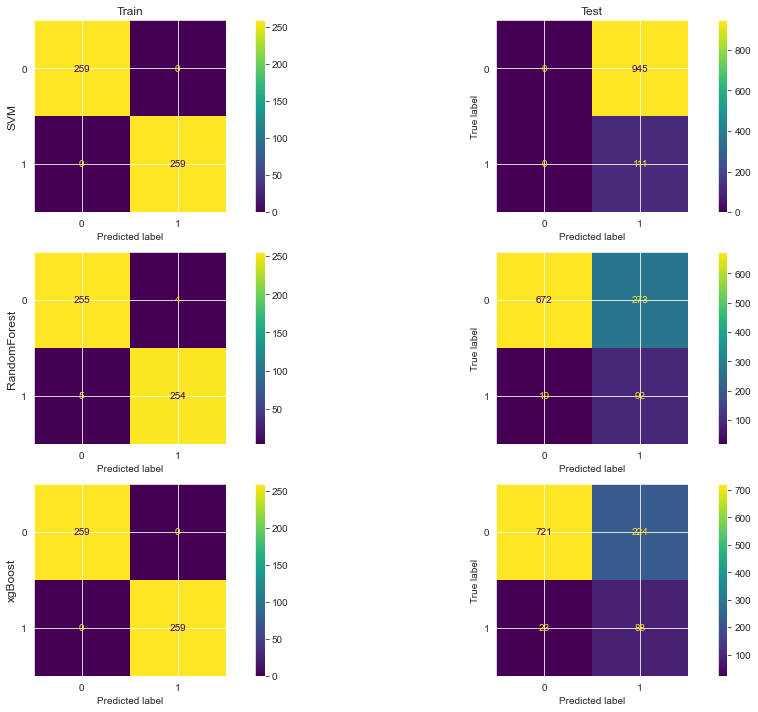

Buscando (SVM)
Mejores parametros: {'C': 0.0001, 'gamma': 0.0001, 'kernel': 'rbf'}
test acurracy 89.49% test recall 0.00% test precision 0.00%
Buscando (RandomForest)
Mejores parametros: {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 200, 'random_state': 42}
test acurracy 89.87% test recall 36.04% test precision 52.63%
Buscando (xgBoost)
Mejores parametros: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 250, 'random_state': 42, 'reg_alpha': 0.1}
test acurracy 90.25% test recall 48.65% test precision 54.00%


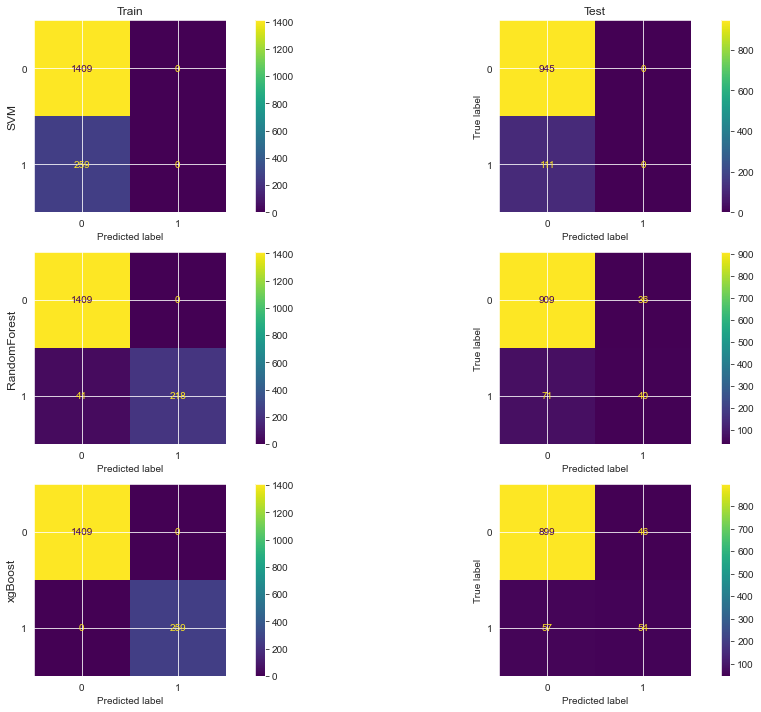

Buscando (SVM)
Mejores parametros: {'C': 0.0001, 'gamma': 0.0001, 'kernel': 'rbf'}
test acurracy 89.49% test recall 0.00% test precision 0.00%
Buscando (RandomForest)
Mejores parametros: {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 200, 'random_state': 42}
test acurracy 91.10% test recall 20.72% test precision 79.31%
Buscando (xgBoost)
Mejores parametros: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'random_state': 42, 'reg_alpha': 0.1}
test acurracy 91.57% test recall 40.54% test precision 66.18%


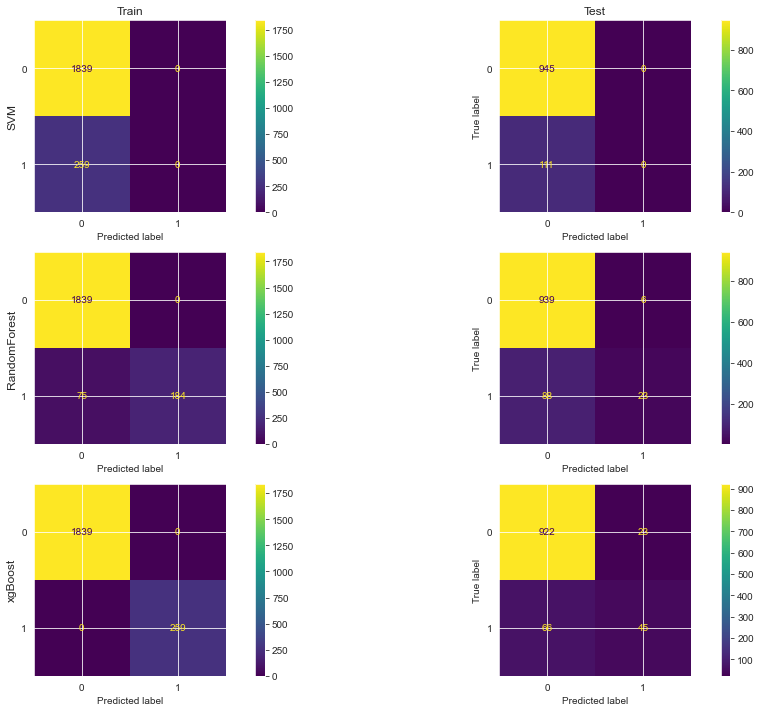

In [9]:
param_svm = {
    'C' : [0.0001,0.001,0.01,1],
    'kernel': ['rbf'],
    'gamma' :[0.0001,0.001,0.01,1]
}


param_rf = {
    'n_estimators':[200,250,300],
    'max_depth' : [6,7,8],
    'criterion' : ['gini'],
    'random_state': [42]
}


param_xgb = {
    'max_depth' : [6,7,8],
    'learning_rate' : [0.1],
    'n_estimators' : [200,250,300],
    'gamma' : [0],
    'reg_alpha' : [0.1],
    'random_state': [42]
}



modelos = ['SVM','RandomForest','xgBoost']
estimators = [SVC(),RandomForestClassifier(),XGBClassifier()]
parametros = [param_svm,param_rf,param_xgb]
samplers = [RandomUnderSampler(),NeighbourhoodCleaningRule(),TomekLinks()]
entrenados = []





for algo in samplers:

    X_res,Y_res = algo.fit_resample(X_train,Y_train)
    fig, axes = plt.subplots(nrows=len(modelos), ncols=2, figsize=(15,10))
    for modelo,estimador,params,ind in zip(modelos,estimators,parametros,range(len(modelos))):
        busqueda = GridSearchCV(estimador,params,scoring='accuracy',refit=True)
        busqueda.fit(X_res,Y_res)
        print('Buscando ({})'.format(modelo))
        print('Mejores parametros:',busqueda.best_params_)
        print('test acurracy {:.2%} test recall {:.2%} test precision {:.2%}'.format(busqueda.score(X_test,Y_test),
                                                                                        recall_score(Y_test,busqueda.predict(X_test)),
                                                                                        precision_score(Y_test,busqueda.predict(X_test))))

        plot_confusion_matrix(busqueda,
                            X_res,
                            Y_res,
                            ax=axes[ind,0])
        #axes[ind,0].title.set_text('Train')

        plot_confusion_matrix(busqueda,
                            X_test,
                            Y_test,
                            ax=axes[ind,1])
        #axes[ind,1].title.set_text('Test')

        entrenados.append(busqueda)

    for ax,col in zip(axes[0],['Train','Test']):
        ax.set_title(col)
    for ax, row in zip(axes[:,0], modelos):
        ax.set_ylabel(row, rotation=90, size='large')

    fig.tight_layout()
    plt.show()

# CNAE56

In [10]:
df_cnae56 = pd.read_csv('Datos/CNAE56-5años.csv')
df_cnae56.drop(df_cnae56.columns[df_cnae56.columns.str.contains('Unnamed: 0',case = False)],axis = 1, inplace = True)

In [11]:
df_cnae56 = limpiar(df_cnae56,5,columnas_anuales)

------------Eliminamos aquellas filas con alguna variable anual completamente vacia, de las no extintas----------
6056
------------Rellenando extremos----------
------------Rellenando Dato-NaN-Dato----------
------------Rellenando Dato-NaN-Dato----------
Extremos 5889
Grupo 3 3866
Grupo 4 2144
Grupo 5 182
TOTAL 12081
------------Rellenando hacia atras----------
------------Rellenando hacia adelante----------


In [12]:
X = df_cnae56
Y = df_cnae56['Y']
X.drop('Y', inplace=True, axis=1)

X.drop(['Nombre', 'Ultimo año disponible', 'Fecha constitución', 'Fecha cambio estado'], inplace=True, axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33)
print('Conjunto de entrenamiento %s' % Counter(Y_train))
print('Conjunto de prueba %s' % Counter(Y_test))

Conjunto de entrenamiento Counter({0: 1803, 1: 566})
Conjunto de prueba Counter({0: 859, 1: 309})


Buscando (SVM)
Mejores parametros: {'C': 0.01, 'gamma': 0.0001, 'kernel': 'rbf'}
test acurracy 84.50% test recall 41.42% test precision 100.00%
Buscando (RandomForest)
Mejores parametros: {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 200, 'random_state': 42}
test acurracy 81.42% test recall 63.43% test precision 65.33%
Buscando (xgBoost)
Mejores parametros: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'random_state': 42, 'reg_alpha': 0.1}
test acurracy 82.02% test recall 70.55% test precision 64.69%


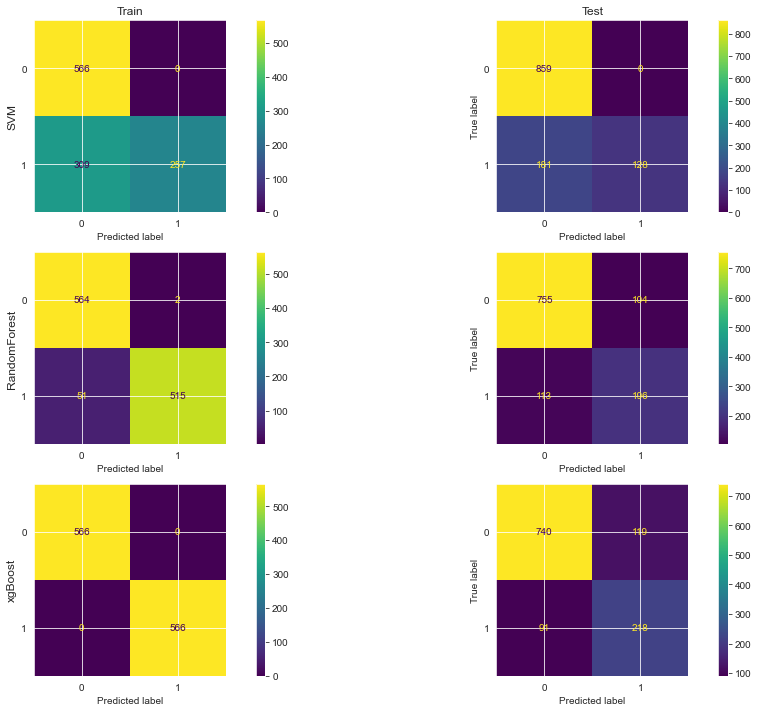

Buscando (SVM)
Mejores parametros: {'C': 0.01, 'gamma': 0.0001, 'kernel': 'rbf'}
test acurracy 84.50% test recall 41.42% test precision 100.00%
Buscando (RandomForest)
Mejores parametros: {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 300, 'random_state': 42}
test acurracy 83.22% test recall 55.34% test precision 74.67%
Buscando (xgBoost)
Mejores parametros: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 250, 'random_state': 42, 'reg_alpha': 0.1}
test acurracy 84.67% test recall 66.34% test precision 73.21%


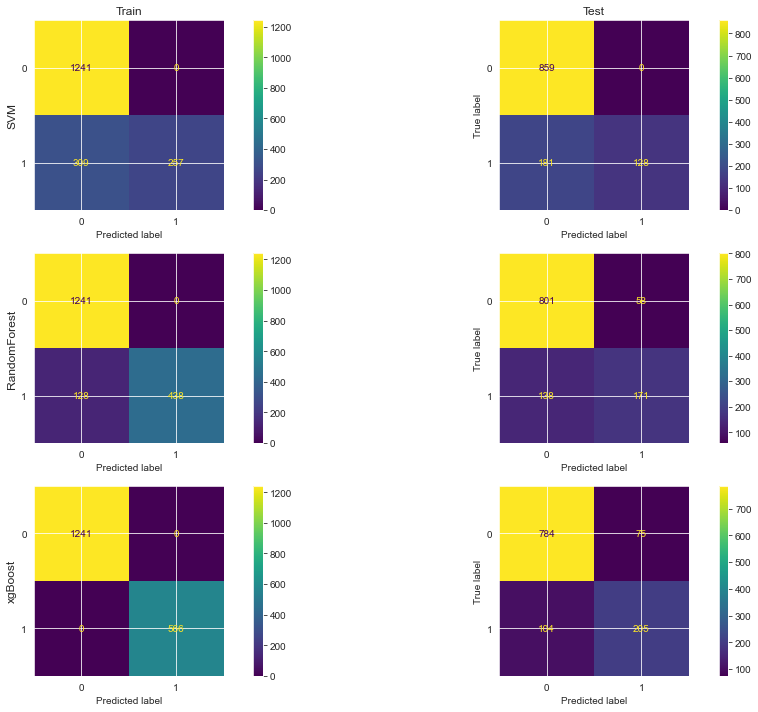

Buscando (SVM)
Mejores parametros: {'C': 0.01, 'gamma': 0.0001, 'kernel': 'rbf'}
test acurracy 84.50% test recall 41.42% test precision 100.00%
Buscando (RandomForest)
Mejores parametros: {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 200, 'random_state': 42}
test acurracy 85.36% test recall 49.19% test precision 91.57%
Buscando (xgBoost)
Mejores parametros: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 250, 'random_state': 42, 'reg_alpha': 0.1}
test acurracy 87.59% test recall 60.84% test precision 88.68%


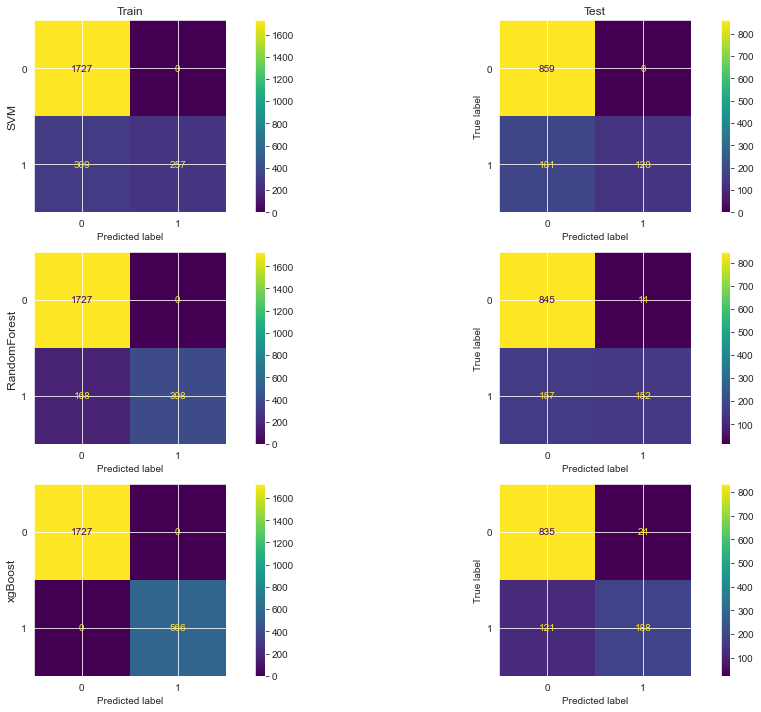

In [13]:
param_svm = {
    'C' : [0.0001,0.001,0.01,1],
    'kernel': ['rbf'],
    'gamma' :[0.0001,0.001,0.01,1]
}


param_rf = {
    'n_estimators':[200,250,300],
    'max_depth' : [6,7,8],
    'criterion' : ['gini'],
    'random_state': [42]
}


param_xgb = {
    'max_depth' : [6,7,8],
    'learning_rate' : [0.1],
    'n_estimators' : [200,250,300],
    'gamma' : [0],
    'reg_alpha' : [0.1],
    'random_state': [42]
}



modelos = ['SVM','RandomForest','xgBoost']
estimators = [SVC(),RandomForestClassifier(),XGBClassifier()]
parametros = [param_svm,param_rf,param_xgb]
samplers = [RandomUnderSampler(),NeighbourhoodCleaningRule(),TomekLinks()]
entrenados = []





for algo in samplers:

    X_res,Y_res = algo.fit_resample(X_train,Y_train)
    fig, axes = plt.subplots(nrows=len(modelos), ncols=2, figsize=(15,10))
    for modelo,estimador,params,ind in zip(modelos,estimators,parametros,range(len(modelos))):
        busqueda = GridSearchCV(estimador,params,scoring='accuracy',refit=True)
        busqueda.fit(X_res,Y_res)
        print('Buscando ({})'.format(modelo))
        print('Mejores parametros:',busqueda.best_params_)
        print('test acurracy {:.2%} test recall {:.2%} test precision {:.2%}'.format(busqueda.score(X_test,Y_test),
                                                                                        recall_score(Y_test,busqueda.predict(X_test)),
                                                                                        precision_score(Y_test,busqueda.predict(X_test))))

        plot_confusion_matrix(busqueda,
                            X_res,
                            Y_res,
                            ax=axes[ind,0])
        #axes[ind,0].title.set_text('Train')

        plot_confusion_matrix(busqueda,
                            X_test,
                            Y_test,
                            ax=axes[ind,1])
        #axes[ind,1].title.set_text('Test')

        entrenados.append(busqueda)

    for ax,col in zip(axes[0],['Train','Test']):
        ax.set_title(col)
    for ax, row in zip(axes[:,0], modelos):
        ax.set_ylabel(row, rotation=90, size='large')

    fig.tight_layout()
    plt.show()